# Catching Hackers

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

log = pd.read_csv('logs/log.csv', index_col='datetime', parse_dates=True)
attacks = pd.read_csv('logs/attacks.csv', parse_dates=True)

attacks.shape, log.shape

((65, 3), (15023, 4))

## Understanding the Data

In [2]:
log.head()

,source_ip,username,success,failure_reason
datetime,,,,
2019-02-01 07:04:35.555010,26.32.56.22,xkim,True,NaN
2019-02-01 08:17:56.308979,37.76.79.196,smith,False,error_wrong_username
2019-02-01 08:17:57.308979,37.76.79.196,osmith,True,NaN
2019-02-01 08:35:53.617958,37.76.79.196,osmith,False,error_wrong_password
2019-02-01 08:35:54.617958,37.76.79.196,osmith,True,NaN


In [3]:
attacks.head()

,start,end,source_ip
0,2019-02-01 13:43:56.246216,2019-02-01 13:48:05.246216,57.23.27.70
1,2019-02-02 21:53:15.373329,2019-02-02 21:54:30.373329,42.145.51.178
2,2019-02-03 07:43:31.329137,2019-02-03 07:47:42.329137,167.30.7.153
3,2019-02-03 12:25:02.566366,2019-02-03 12:29:17.566366,38.123.57.42
4,2019-02-03 14:46:41.583987,2019-02-03 14:50:47.583987,77.223.117.145


Text(0.5, 0.98, 'Unique IP addresses seen in a given hour across time period')

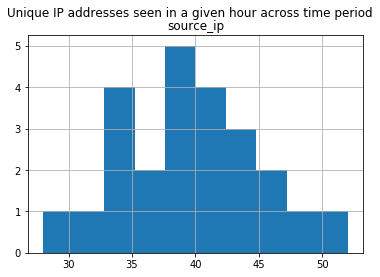

In [4]:
log.assign(hour=lambda x: x.index.hour).groupby('hour').agg({'source_ip':'nunique'}).hist()
plt.suptitle('Unique IP addresses seen in a given hour across time period')

## EDA

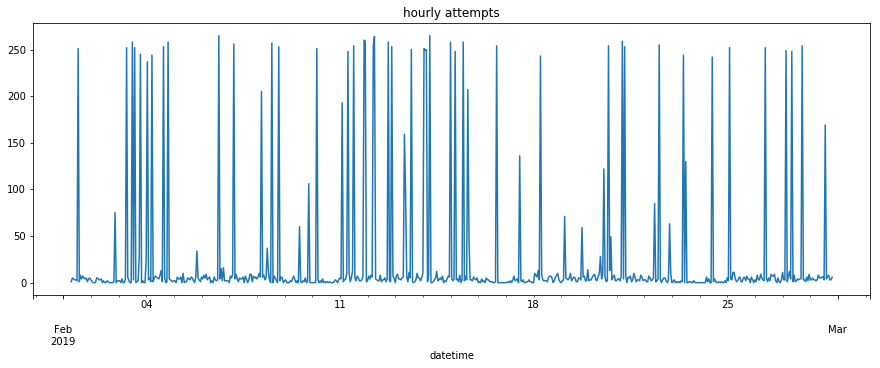

In [5]:
# attempts over time
log.assign(attempts=1).attempts.resample('1H').sum().plot(
    figsize=(15, 5), title='hourly attempts'
)

In [6]:
log.source_ip.value_counts().describe()

count    285.000000
mean      52.712281
std       88.652757
min        1.000000
25%        5.000000
50%       10.000000
75%       30.000000
max      258.000000
Name: source_ip, dtype: float64

Text(0.5, 0.98, 'Attempts per IP Address')

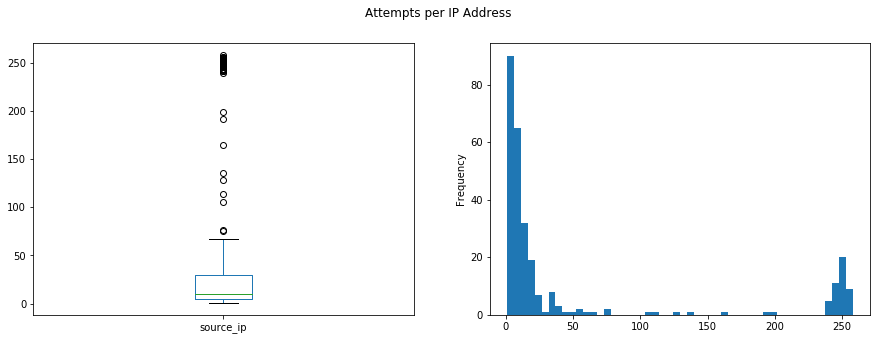

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
log.source_ip.value_counts().plot(kind='box', ax=axes[0])
log.source_ip.value_counts().plot(kind='hist', bins=50, ax=axes[1])
fig.suptitle('Attempts per IP Address')

What percent of the top IP addresses are hackers?

In [8]:
num_hackers = attacks.source_ip.shape[0]
log.source_ip.value_counts().index[:num_hackers]\
    .isin(attacks.source_ip).sum() / num_hackers

0.9076923076923077

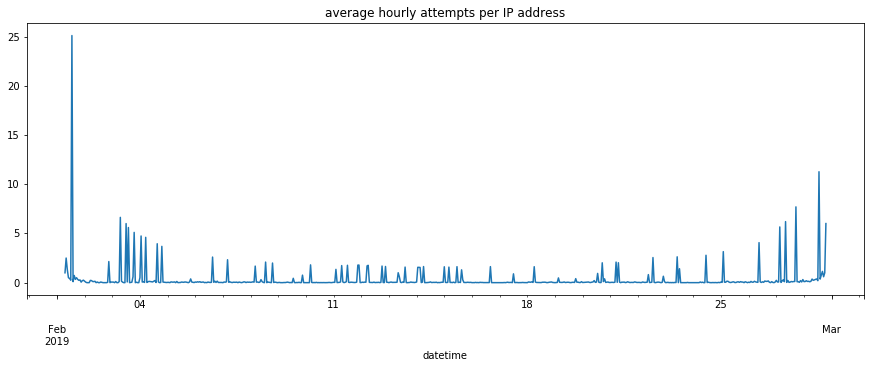

In [9]:
# attempts per ip address
log.assign(attempts=1).groupby('source_ip').attempts\
    .resample('1H').sum().unstack().mean()\
    .plot(figsize=(15, 5), title='average hourly attempts per IP address')

What percent of the time was a hacker's attempt successful?

In [10]:
log[log.source_ip.isin(attacks.source_ip)]\
    .success.value_counts(normalize=True)

False    0.836524
True     0.163476
Name: success, dtype: float64

What percent of the time are valid users' attempts successful?

In [11]:
log[~log.source_ip.isin(attacks.source_ip)]\
    .success.value_counts(normalize=True)

True     0.597484
False    0.402516
Name: success, dtype: float64

Why is each group failing?

In [12]:
pd.crosstab(
    index=pd.Series(
        log.source_ip.isin(attacks.source_ip), name='is_hacker'
    ), columns=log.failure_reason
)

failure_reason,error_account_locked,error_wrong_password,error_wrong_username
is_hacker,,,
False,101,450,345
True,93,3967,6645


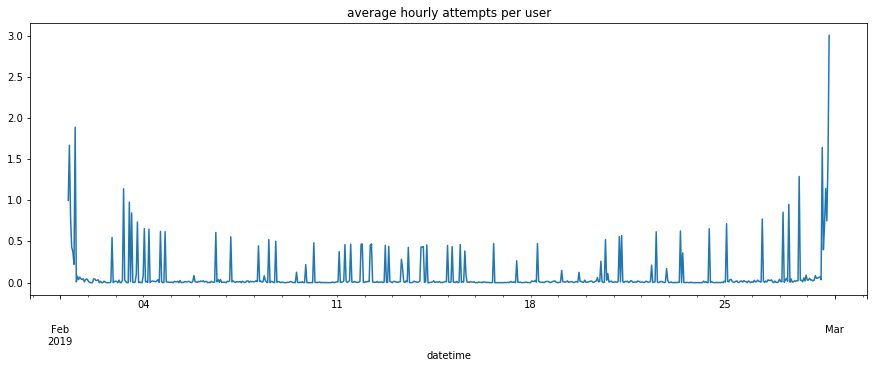

In [13]:
# attempts per user
log.assign(attempts=1).groupby('username').attempts\
    .resample('1H').sum().unstack().mean()\
    .plot(figsize=(15, 5), title='average hourly attempts per user')

Calculate metrics per IP address

In [14]:
pivot = pd.pivot_table(
    log, values='success', index=log.source_ip, 
    columns=log.failure_reason.fillna('success'), 
    aggfunc='count', fill_value=0
)
pivot.insert(0, 'attempts', pivot.sum(axis=1))
pivot = pivot.sort_values('attempts', ascending=False).assign(
    success_rate=lambda x: x.success / x.attempts,
    error_rate=lambda x: 1 - x.success_rate
)
pivot.head()

failure_reason,attempts,error_account_locked,error_wrong_password,error_wrong_username,success,success_rate,error_rate
source_ip,,,,,,,
153.175.108.118,258,0,73,149,36,0.139535,0.860465
162.108.141.30,256,2,90,119,45,0.175781,0.824219
76.53.83.236,256,4,81,141,30,0.117188,0.882812
38.123.57.42,255,0,76,140,39,0.152941,0.847059
13.188.93.3,255,2,92,124,37,0.145098,0.854902


In [15]:
pivot.sort_values('success_rate', ascending=False).head()

failure_reason,attempts,error_account_locked,error_wrong_password,error_wrong_username,success,success_rate,error_rate
source_ip,,,,,,,
253.21.45.71,1,0,0,0,1,1.0,0.0
124.178.25.98,2,0,0,0,2,1.0,0.0
27.140.145.181,4,0,0,0,4,1.0,0.0
125.15.117.120,2,0,0,0,2,1.0,0.0
126.124.56.18,2,0,0,0,2,1.0,0.0


In [16]:
pivot.describe()

failure_reason,attempts,error_account_locked,error_wrong_password,error_wrong_username,success,success_rate,error_rate
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,52.712281,0.680702,15.498246,24.526316,12.007018,0.537931,0.462069
std,88.652757,1.138234,28.034640,47.662585,13.629399,0.279047,0.279047
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,1.000000,0.000000,3.000000,0.280000,0.250000
50%,10.000000,0.000000,2.000000,2.000000,6.000000,0.545455,0.454545
75%,30.000000,1.000000,7.000000,7.000000,13.000000,0.750000,0.720000
max,258.000000,5.000000,96.000000,153.000000,51.000000,1.000000,1.000000


Distinct users per IP address

In [17]:
log.groupby('source_ip').agg(
    dict(username='nunique')
).username.value_counts().describe()

count    41.000000
mean      6.951220
std      17.036653
min       1.000000
25%       1.000000
50%       1.000000
75%       4.000000
max      86.000000
Name: username, dtype: float64

### Visual Anomaly Detection

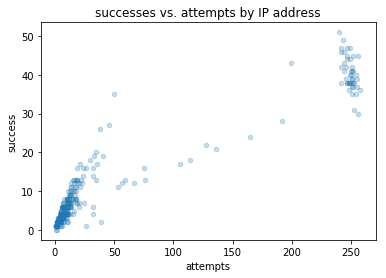

In [18]:
pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP address', alpha=0.25
)

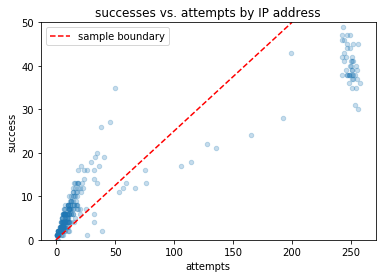

In [19]:
ax = pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP address', alpha=0.25
)
x = np.linspace(0, 200)
ax.plot(x, .25*x, 'r--', label='sample boundary')
plt.ylim(0, 50)
plt.legend()

Text(0.5, 0.98, 'successes vs. attempts by IP address')

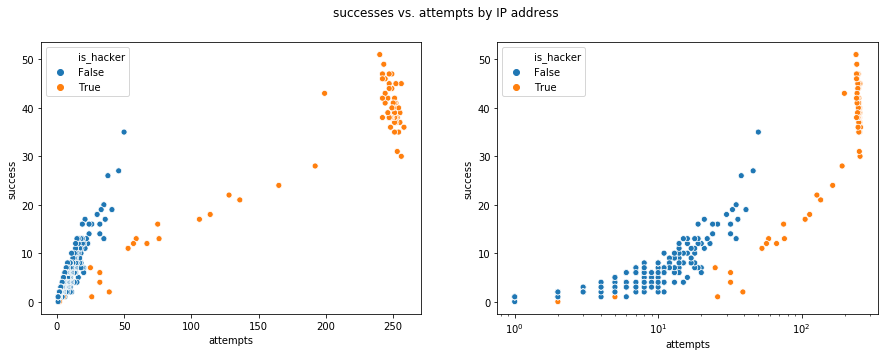

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax in axes:
    sns.scatterplot(
        y=pivot.success, x=pivot.attempts, 
        hue=pivot.assign(
            is_hacker=lambda x: x.index.isin(attacks.source_ip)
        ).is_hacker,
        ax=ax
    )
axes[1].set_xscale('log')
plt.suptitle('successes vs. attempts by IP address')

attempts       AxesSubplot(0.125,0.125;0.352273x0.755)
success     AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

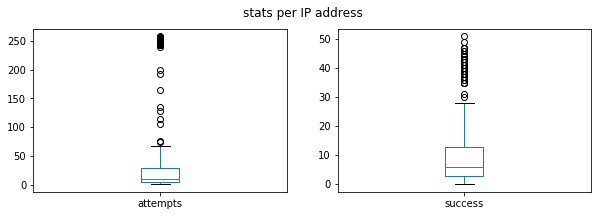

In [21]:
pivot[['attempts', 'success']].plot(
    kind='box', subplots=True, figsize=(10, 3),
    title='stats per IP address'
)

## Rule-based Anomaly Detection

In [22]:
hourly_ip_logs = log.assign(
    failures=lambda x: np.invert(x.success)
).groupby('source_ip').resample('1H').agg(
    {'username': 'nunique', 'success':'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures,
    success_rate=lambda x: x.success / x.attempts,
    failure_rate=lambda x: 1 - x.success_rate
).dropna().reset_index()

In [23]:
hourly_ip_logs.head()

,source_ip,datetime,username,success,failures,attempts,success_rate,failure_rate
0,1.218.123.66,2019-02-06 20:00:00,1,1.0,0.0,1.0,1.0,0.0
1,1.218.123.66,2019-02-07 18:00:00,1,2.0,0.0,2.0,1.0,0.0
2,1.218.123.66,2019-02-07 19:00:00,1,0.0,3.0,3.0,0.0,1.0
3,100.208.255.37,2019-02-07 09:00:00,1,0.0,4.0,4.0,0.0,1.0
4,100.208.255.37,2019-02-08 05:00:00,1,2.0,0.0,2.0,1.0,0.0


In [24]:
attacks.source_ip.nunique() / log.source_ip.nunique()

0.22807017543859648

### Percent Difference from Threshold

In [25]:
def get_baselines(hourly_ip_logs, func, *args, **kwargs):
    """Calculate hourly statistic per column."""
    if isinstance(func, str):
        func = getattr(pd.DataFrame, func)
    return hourly_ip_logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).groupby('hour').apply(
        lambda x: x.sample(10, random_state=0, replace=True).pipe(func, *args, **kwargs)
    )

In [26]:
averages = get_baselines(hourly_ip_logs, 'mean')

In [27]:
averages.shape

(24, 7)

In [28]:
averages.head()

,username,success,failures,attempts,success_rate,failure_rate,hour
hour,,,,,,,
0,1.5,1.6,1.1,2.7,0.733333,0.266667,0.0
1,1.1,1.3,0.3,1.6,0.891667,0.108333,1.0
2,1.6,1.1,1.5,2.6,0.561905,0.438095,2.0
3,5.5,2.2,6.5,8.7,0.651244,0.348756,3.0
4,15.0,5.1,21.3,26.4,0.815385,0.184615,4.0


In [29]:
def pct_change_threshold(hourly_ip_logs, baselines, pcts=None):
    """
    Return flagged IP addresses based on thresholds.
    
    Parameters:
        - hourly_ip_logs: Aggregated hourly data per IP address.
        - baselines: Hourly baselines per column in data.
        - pcts: Dictionary of custom percentages per column for
                calculating upper bound thresholds (baseline * pct).
                If not provided, upper bounds will be:
                    - 4: usernames per IP address
                    - 1.5: attempts per IP address
                    - 0.5: failure rate per IP address
    
    Returns:
        Pandas series containing the IP addresses flagged.
    """
    pcts = {} if not pcts else pcts

    return hourly_ip_logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).join(
        baselines, on='hour', rsuffix='_baseline'
    ).assign(
        too_many_users=lambda x: x.username_baseline \
            * pcts.get('username', 4) <= x.username,
        too_many_attempts=lambda x: x.attempts_baseline \
            * pcts.get('attempts', 1.5) <= x.attempts,
        high_failure_rate=lambda x: x.failure_rate_baseline \
            * pcts.get('failure_rate', 1.5) <= x.failure_rate
    ).query(
        'too_many_users and too_many_attempts and high_failure_rate'
    ).source_ip.drop_duplicates()

In [30]:
pct_from_mean_ips = pct_change_threshold(hourly_ip_logs, averages)
pct_from_mean_ips.nunique()

56

### Tukey Fence

In [31]:
q3 = get_baselines(hourly_ip_logs, 'quantile', .75).drop(columns=['hour'])
q1 = get_baselines(hourly_ip_logs, 'quantile', .25).drop(columns=['hour'])
iqr = q3 - q1
upper_bound = (q3 + 1.5*iqr).reset_index()

In [32]:
tukey_fence_flags = pct_change_threshold(
    hourly_ip_logs, upper_bound, 
    pcts={key: 1 for key in ['username', 'attempts', 'failure_rate']}
)

In [33]:
tukey_fence_flags.nunique()

75

### Z-score

In [34]:
std_dev = get_baselines(hourly_ip_logs, 'std').drop(columns=['hour'])

z_score_ips = hourly_ip_logs.assign(
        hour=lambda x: x.datetime.dt.hour
).join(
    std_dev.join(
        averages.drop(columns=['hour']), 
        lsuffix='_std', 
        rsuffix='_mean'
    ),
    on='hour'
).assign(
    too_many_users=lambda x: (
        x.username - x.username_mean
    )/x.username_std >= 3,
    too_many_attempts=lambda x:  (
        x.attempts - x.attempts_mean
    )/x.attempts_std >= 3,
    high_failure_rate=lambda x:  (
        x.failure_rate - x.failure_rate_mean
    )/x.failure_rate_std >= 3
).query(
    'too_many_users and too_many_attempts and high_failure_rate'
).source_ip.drop_duplicates()

z_score_ips.nunique()

7

### Evaluating methods

In [35]:
def evaluate(alerted_ips, attack_ips, log_ips):
    """
    Calculate true positives (TP), false positives (FP), 
    true negatives (TN), and false negatives (FN) for 
    IP addresses flagged as suspicious.
    
    Parameters:
        - alerted_ips: Pandas series of flagged IP addresses
        - attack_ips: Pandas series of attacker IP addresses
        - log_ips: Pandas series of all IP addresses seen
    
    Returns:
        Tuple of form (TP, FP, TN, FN)
    """
    tp = alerted_ips.isin(attack_ips).sum()
    tn = log_ips[log_ips.isin(alerted_ips)].isin(attack_ips).sum()
    fp = np.invert(
        log_ips[log_ips.isin(alerted_ips)].isin(attack_ips)
    ).sum()
    fn = np.invert(
        log_ips[log_ips.isin(attack_ips)].isin(alerted_ips)
    ).sum()
    return tp, fp, tn, fn

In [36]:
# make this easier to call
from functools import partial
scores = partial(evaluate, attack_ips=attacks.source_ip, log_ips=pivot.index)

#### percent difference from mean

In [37]:
pct_from_mean_ips.isin(attacks.source_ip).value_counts(
    normalize=True
)

True    1.0
Name: source_ip, dtype: float64

In [38]:
tp, fp, tn, fn = scores(pct_from_mean_ips)

In [39]:
# recall 
tp / (tp + fn)

0.8615384615384616

In [40]:
def classification_stats(tp, fp, tn, fn):
    """Calculate accuracy, precision, recall, and F1-score"""
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * precision * recall / (precision + recall)
    return {
        'accuracy' : (tp + tn) / (tp + fp + tn + fn),
        'precision' : precision,
        'recall' : recall,
        'F1-score' : f1_score
    }

In [41]:
classification_stats(tp, fp, tn, fn)

{'accuracy': 0.9256198347107438,
 'precision': 1.0,
 'recall': 0.8615384615384616,
 'F1-score': 0.9256198347107438}

#### percent difference from the median

In [42]:
medians = get_baselines(hourly_ip_logs, 'median')
pct_from_median_ips = pct_change_threshold(hourly_ip_logs, medians)
tp, fp, tn, fn = scores(pct_from_median_ips)
classification_stats(tp, fp, tn, fn)

{'accuracy': 0.926829268292683,
 'precision': 0.9827586206896551,
 'recall': 0.8769230769230769,
 'F1-score': 0.9268292682926829}

#### comparing methods

In [43]:
pd.DataFrame({
    method : classification_stats(*scores(ips)) \
    for method, ips in {
        'means' : pct_from_mean_ips,
        'medians' : pct_from_median_ips,
        'tukey fence' : tukey_fence_flags,
        'z-scores' : z_score_ips
    }.items()
})

,means,medians,tukey fence,z-scores
F1-score,0.925620,0.926829,0.300000,0.166667
accuracy,0.925620,0.926829,0.300000,0.166667
precision,1.000000,0.982759,0.280000,0.857143
recall,0.861538,0.876923,0.323077,0.092308
